In [1]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [2]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

2023-10-16 10:30:42.235172: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12648448]{0}, u32[12648448]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-16 10:30:42.358946: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.123851471s
Constant folding an instruction is taking > 1s:

  %fusion.5 = (u32[12648448]{0}, u32[12648448]{0}) fusion(), kind=kLoop, calls=%horizontally_fused_computation

This isn't necessarily a bug; constant-folding is inherently a trade-off betwee

In [3]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)
pstate = replicate(state)

In [4]:
logging_dir = '../logging/proposals/'
run_name = 'autumn-darkness-67'
# run_name = 'faithful-river-68'  # No crops

In [5]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state,)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [6]:
from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord', 
         '../data/tfrecords/observations_5.tfrecord','../data/tfrecords/observations_6.tfrecord','../data/tfrecords/observations_7.tfrecord','../data/tfrecords/observations_8.tfrecord',
         '../data/tfrecords/observations_9.tfrecord']

ds = make_dataloader(files, batch_size=32, seed=42, split='val')
batches = iter(ds)

## Zero-shot classification

In [62]:
import jax.numpy as np

images, captions = next(iter(ds))
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [63]:
from dm_pix import center_crop

images = center_crop(images, 224, 224)
inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)

In [64]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")
claude_science_cat = ["star forming galaxies", "lyman alpha", "sfr", "dust", "crowded stellar field", "core-collapse supernova", "cosmology",  "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "neutron stars", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "galaxy clusters", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "dwarf galaxies", "low surface brightness galaxies", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "mass segregation", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "HII regions", "planetary nebulae", "supernova remnants", "stellar winds", "Wolf–Rayet stars", "OB stars", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar oscillations", "stellar abundances", "stellar rotation", "stellar magnetic fields", "stellar dynamics", "compact stellar remnants", "Einstein rings", "asteroids", "comets", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]
claude_science_cat_inputs = tokenizer(claude_science_cat, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

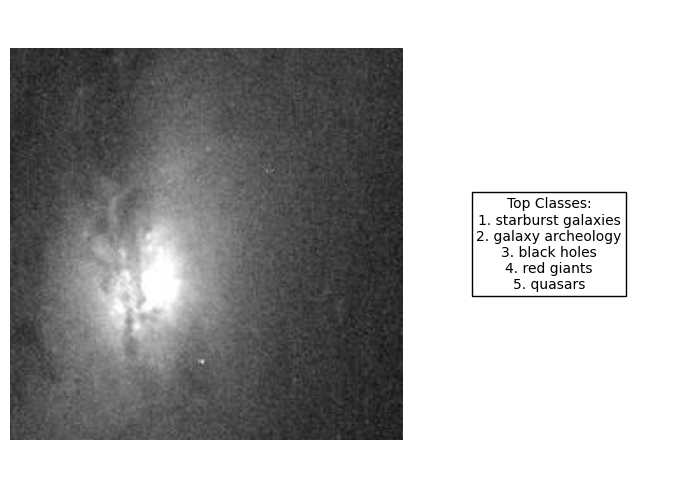

Category: GALAXIES. Small nuclear black holes are the last major unexplored part of BH parameter space. We propose to search for the smallest BHs that HST can possibly find. Past studies have concentrated on massive, distant spheroids, overlooking many BH candidates on our own doorstep. The minimum detectable BH mass can be driven down by nearly two orders of magnitude by focusing on the nearest galaxies. We can easily reach down to 10^5 M{sun}, the probable mass of the ``first born'' objects that {in other cases} grow or merge up to the quasar mass range. This strategy also favors disklike ``pseudobulges'', which probably formed differently from classical spheroids and which therefore provide a fresh perspective on the relationship between BHs and their embryonic environments. Our complete sample of 20 nearby galaxies includes all unstudied objects within 7.5 Mpc, brighter than M_B = -17, with well defined, unobscured centers. STIS long-slit spectra will be used to measure BH masses u

In [73]:
idx = 6

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

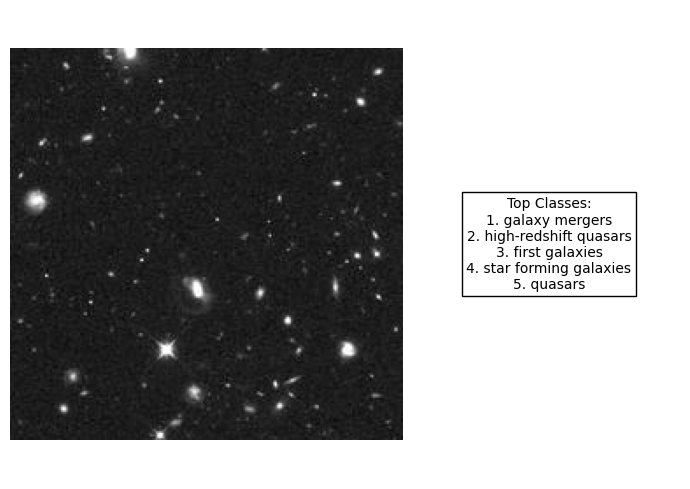

Category: COSMOLOGY. Hubble/WFC3 observations transformed our view of early galaxy formation by building reliable samples of galaxies out to redshift z~8, ~700 Myr after the Big Bang and hinting at a dramatic evolution in properties at yet earlier times. From z~8 to z~10 (~200Myr) the luminosity density seems to decrease by a factor ten, but bright galaxies may remain relatively common, based on the four z>9 objects detected so far with m_AB<27. To investigate this apparent conundrum, and study the formation of the most massive and luminous galaxies at ~500 Myr without being affected by cosmic variance, we propose a random-pointing survey to detect 20+/-5 galaxies at z ~ 9-10 as faint as m_AB=27.1 (5-sigma) at zero prime orbit cost. This request builds on our successful Cycle 17 & 19 Brightest of Reionizing Galaxies (BoRG) Survey, which found the largest sample of L>L* galaxies at z~8. BoRG[z8] demonstrated, by adding constraints from the Ultra Deep Field (UDF), that the luminosity fun

In [66]:
idx = 16

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

## Image retrieval

In [109]:
from tqdm.notebook import tqdm

In [110]:
from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/tfrecords/observations_1.tfrecord','../data/tfrecords/observations_2.tfrecord','../data/tfrecords/observations_3.tfrecord','../data/tfrecords/observations_4.tfrecord', 
         '../data/tfrecords/observations_5.tfrecord','../data/tfrecords/observations_6.tfrecord','../data/tfrecords/observations_7.tfrecord','../data/tfrecords/observations_8.tfrecord',
         '../data/tfrecords/observations_9.tfrecord']

ds = make_dataloader(files, batch_size=32, seed=42, split='train')
batches = iter(ds)

In [112]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for _ in tqdm(range(200)):

    images, captions = next(iter(ds))
    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)


  0%|          | 0/200 [00:00<?, ?it/s]

In [198]:
# ["andromeda m1", "dwarf galaxies and globular clusters", "gravitational lensing", "ISM"]

In [214]:
query = "dwarf galaxies and globular clusters"
query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")

text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)

In [215]:
sorted_idxs = np.argsort((np.vstack(image_feat_stack) @ text_feat.T)[:, 0])[::-1]

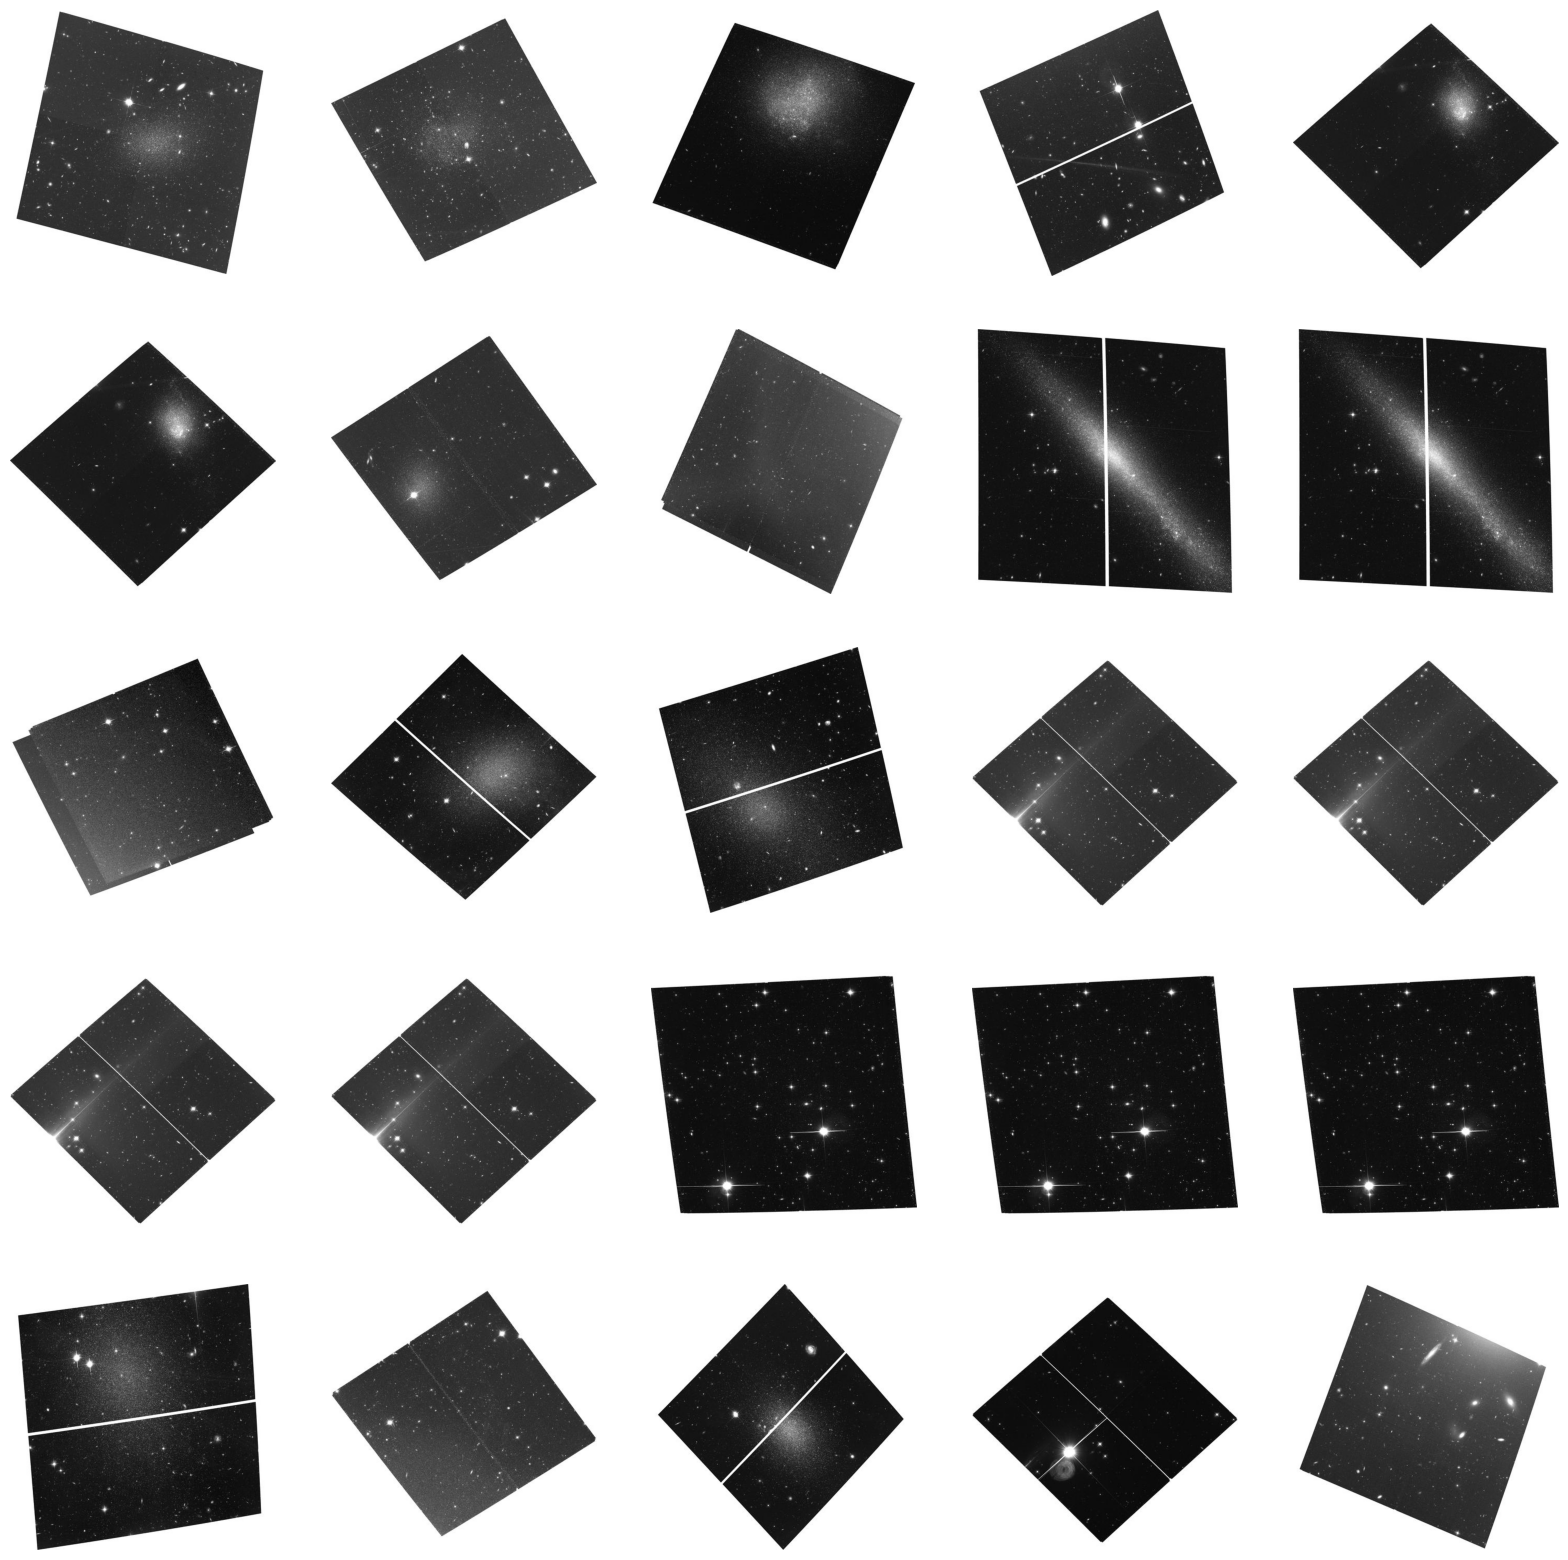

In [216]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))

grid_size = 5

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(images_stack[sorted_idxs[i] // 32][sorted_idxs[i] % 32], vmin=0, vmax=1)
    plt.axis('off')  # Turn off axis numbers and ticks

plt.show()

In [217]:
[captions_stack[idx] for idx in sorted_idxs][:25]

["Category: STELLAR POPULATIONS. We seek HST ACS/WFC time to conduct a detailed study of the stellar populations of 5 early-type {dE, dE/dIrr} dwarf galaxies in the nearby {~1.5 to 4 Mpc} Sculptor group.  Four of these systems have been recently found to contain modest amounts of HI, and existing ground-based and HST snapshot data point to the potential presence of small populations of young {blue} stars in at least three of these systems. Consequently, they resemble the Local Group 'transition' objects Phoenix and LGS3.  The relative number of such transition systems is thus substantially larger in the low density environment of the Scl group than for the Local Group.  Detailed stellar populations studies will allow estimation of the star formation histories, via stellar population modelling of the color-magnitude diagrams, of the target dwarfs, which in turn will connect to gas consumption and retention rates.  For the two nearer dwarfs we aim to reach below the horizontal branch {a 